# General imports

In [1]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
from typing import Tuple
from collections import defaultdict
from gekko import GEKKO
from itertools import product
import numpy as np

# pybbn imports

In [2]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController


### create the nodes
a= BbnNode(Variable(0, 'a', ['on', 'off']), [0.5, 0.5])
b = BbnNode(Variable(1, 'b', ['on', 'off']), [0.5, 0.5, 0.4, 0.6])
c = BbnNode(Variable(2, 'c', ['on', 'off']), [0.7, 0.3, 0.2, 0.8])
d = BbnNode(Variable(3, 'd', ['on', 'off']), [0.9, 0.1, 0.5, 0.5])
e = BbnNode(Variable(4, 'e', ['on', 'off']), [0.3, 0.7, 0.6, 0.4])
f = BbnNode(Variable(5, 'f', ['on', 'off']), [0.01, 0.99, 0.01, 0.99, 0.01, 0.99, 0.99, 0.01])
g = BbnNode(Variable(6, 'g', ['on', 'off']), [0.8, 0.2, 0.1, 0.9])
h = BbnNode(Variable(7, 'h', ['on', 'off']), [0.05, 0.95, 0.95, 0.05, 0.95, 0.05, 0.95, 0.05])

### create the network structure
bbn = Bbn() \
    .add_node(a) \
    .add_node(b) \
    .add_node(c) \
    .add_node(d) \
    .add_node(e) \
    .add_node(f) \
    .add_node(g) \
    .add_node(h) \
    .add_edge(Edge(a, b, EdgeType.DIRECTED)) \
    .add_edge(Edge(a, c, EdgeType.DIRECTED)) \
    .add_edge(Edge(b, d, EdgeType.DIRECTED)) \
    .add_edge(Edge(c, e, EdgeType.DIRECTED)) \
    .add_edge(Edge(d, f, EdgeType.DIRECTED)) \
    .add_edge(Edge(e, f, EdgeType.DIRECTED)) \
    .add_edge(Edge(c, g, EdgeType.DIRECTED)) \
    .add_edge(Edge(e, h, EdgeType.DIRECTED)) \
    .add_edge(Edge(g, h, EdgeType.DIRECTED))

# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)



# print the posterior probabilities
for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

## sample code for evidence

In [3]:
# insert an observation evidence
def build_evidence(tree,node,value):
    state = "on" if value==1 else "off"
    ev = EvidenceBuilder() \
    .with_node(tree.get_bbn_node(node)) \
    .with_evidence(state, value) \
    .build()
    tree.set_observation(ev)
    

In [4]:
def get_binary_for_all_nodes(tree, model):
    # #x = [m.Var(integer=True, lb=0,ub=1) for i in range(len(tree.get_bbn_nodes()))]
    # x={}
    # for i,node in enumerate(tree.get_bbn_nodes()):
    #     x[i]= model.Var(integer=True, lb=0, ub = 1)
    number_of_nodes = len(tree.get_bbn_nodes())
    x = model.Array(model.CV, (number_of_nodes), lb = 0, ub = 1, integer = True, value = 1)
  
    return x

In [5]:
def posterior_proba(tree,binary_variables,node):
    for i,value in enumerate(binary_variables):
        if i!= node:
            build_evidence(tree,i,value.value)
    proba = join_tree.get_posteriors()[map_nx_to_bbn[node]] 
    
    tree.unobserve_all()
    return proba["on"]
    

simple model graph to test if it works correctly

In [37]:
a= BbnNode(Variable(0, 0, ['on', 'off']), [0.5, 0.5])
b = BbnNode(Variable(1, 1, ['on', 'off']), [0.7, 0.3, 0.4, 0.6])
c = BbnNode(Variable(2, 2, ['on', 'off']), [0.9, 0.1, 0.4, 0.6])

# create the network structure
bbn = Bbn() \
    .add_node(a) \
    .add_node(b) \
    .add_node(c) \
    .add_edge(Edge(a, b, EdgeType.DIRECTED)) \
    .add_edge(Edge(b, c, EdgeType.DIRECTED)) 

# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)



# print the posterior probabilities
for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

1 : on=0.55000, off=0.45000
0 : on=0.50000, off=0.50000
2 : on=0.67500, off=0.32500


In [38]:
g, map_nx_to_bbn = bbn.to_nx_graph()
map_nx_to_bbn
map_bbn_to_nx = dict((v,k) for k,v in map_nx_to_bbn.items())

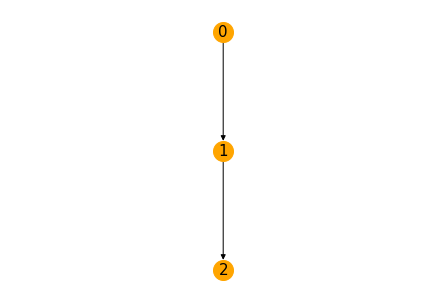

In [39]:
my_pos = graphviz_layout(g, prog="dot" )
nx.draw(g, pos = my_pos, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)
plt.show()

In [9]:
def backwards_traversal(g:nx.DiGraph,source:int)->list:
    queue = [source]
    for node in queue:
        queue += list(g.predecessors(node))
    return queue

In [10]:
def forward_traversal(queue:list) -> list:
    x = [0 for i in range(len(queue))]
    

## flattened LP

In [11]:
matrix_model = GEKKO()
m = matrix_model.Array(matrix_model.Const,8)#(4))
for i in range(8):
    m[i] = i*0.1


x = matrix_model.Array(matrix_model.Var,8, lb=0, ub=1, integer = True, value = 0)
z = matrix_model.Var(lb=0, ub=8, integer=True)

matrix_model.Equation(sum(x)==1)
for i in range(8):
    matrix_model.Equation(m[i] >= 0.5*x[i])
    matrix_model.Equation(sum(int(i) for i in np.binary_repr(i)) * x[i]<=z)


#TODO in need of optimization func
matrix_model.Minimize(-m@x +z)
matrix_model.options.SOLVER = 1
print(m)
matrix_model.solve(disp=True)

print(x )


[0.0 0.1 0.2 0.30000000000000004 0.4 0.5 0.6000000000000001
 0.7000000000000001]
apm 79.206.189.254_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            8
   Variables    :           25
   Intermediates:            0
   Connections  :            0
   Equations    :           18
   Residuals    :           18
 
 Number of state variables:             25
 Number of total equations: -           17
 Number of slack variables: -           16
 ---------------------------------------
 Degrees of freedom       :             -8
 
 * Warning: DOF <= 0
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.

In [12]:
np.array([[2,3,1],[2,2,1]])[(1,1)]

2

# Matrix LP with new objective

In [13]:
permutations = tuple(product(range(2),repeat = 1 ))
permutations

((0,), (1,))

In [14]:
def model_permutation_equations(model, cpt, realization, binary_variables, threshold:float=0.5):
    is_taken = 1
    for i,instant_state in enumerate(realization):
        is_taken *= (1-binary_variables[i]) if instant_state == 0 else binary_variables[i]
    print(f"cpt:{cpt[realization]}, is_taken:{is_taken}, threshold:{threshold}")
    model.Equation(cpt[realization] >= is_taken*threshold)
    

In [15]:
model = GEKKO()
m = model.Array(model.Const,(2))#(4))
m[(0)] = 0.4
m[(1)] = 0.5

#m = numpy_array


x = model.Array(model.Var,1, lb=0, ub=1, integer = True, value = 0)
threshold = model.Param(0.5, integer = True)
y = model.Array(model.Var, 2)
z = model.Var()

for realization in permutations:
    model_permutation_equations(model, m,realization,x)

model.Equation(z == sum(2**i * xi for i, xi in enumerate(x)))

for i,yi in enumerate(y):
    model.Equation(yi == 0**((i-z)**2))#model.if3(-model.abs3(i-xi),0,1))
    #model.Equation(yi == model.abs3(i-z))


#TODO in need of optimization func
model.Minimize(  model.sum(x) - m.flatten()@y)
model.options.SOLVER = 1
print(x)
print(m)
model.solve(disp=True)

print(x,  y )

cpt:0.4, is_taken:((1)*((1-int_v1))), threshold:0.5
cpt:0.5, is_taken:((1)*(int_v1)), threshold:0.5
[0]
[0.4 0.5]
apm 79.206.189.254_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            2
   Variables    :            7
   Intermediates:            0
   Connections  :            0
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:              6
 Number of total equations: -            5
 Number of slack variables: -            2
 ---------------------------------------
 Degrees of freedom       :             -1
 
 * Warning: DOF <= 0
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 -------------------------------------------

Tree-based modelling:
1. Create backwards traversal
2. create CPT for each node
3. 

In [42]:
class LazyLearner:

    def __init__(self, nx_graph,join_tree,
    #  map_bbn_to_nx, 
    #  map_nx_to_bbn,
     ) -> None:
        self.G = nx_graph
        self.join_tree = join_tree
        # self.map_nx_to_bbn = map_nx_to_bbn
        # self.map_bbn_to_nx = map_bbn_to_nx
    
    def build_evidence(self,node,value):
        state = "on" if value==1 else "off"
        ev = EvidenceBuilder() \
        .with_node(self.join_tree.get_bbn_node(node)) \
        .with_evidence(state, value) \
        .build()
        self.join_tree.set_observation(ev)

    
    
    def posterior_proba(self,parent_node_states:tuple, permutation_to_node_map:tuple,node)-> float:
        for binary_value, parent_node in zip(parent_node_states, permutation_to_node_map):
            self.build_evidence(parent_node,binary_value)
        proba = self.join_tree.get_posteriors()[node] 
        
        self.join_tree.unobserve_all()
        return proba["on"]

    def create_CPT(self,node:int) -> np.array:
        parents=tuple(self.G.predecessors(node))
        return (
            self.model.Array(self.model.Const,1,value = self.posterior_proba((), (), node))
            if parents == ()
            else self.create_CPT_with_parents(node)
        )

    def parent_permutations(self, node)-> tuple:
        parents=tuple(self.G.predecessors(node))
        num_parents = len(parents)
        permutations = tuple(product(range(2),repeat = num_parents ))
        
        return permutations, parents
        
    # TODO Rename this here and in `create_CPT`
    def create_CPT_with_parents(self, node):
        permutations, parents = self.parent_permutations(node)
        num_parents = len(parents)
        dimensions = tuple(2 for i in range(num_parents))
        cpt = self.model.Array(self.model.Const, dimensions)
        
        for permutation in permutations:
            cpt[permutation] = self.posterior_proba(permutation,parents,node)
        return cpt

    def backwards_traversal(self,target_node:int)->list:
        queue = list(self.G.predecessors(target_node))
        for node in queue:
            queue += list(self.G.predecessors(node))
        return queue
    
    def create_CPT_for_all_nodes(self,Q, target_node):
        return {node: self.create_CPT(node) for node in Q+[target_node]}

    def create_binary_variables(self,Q):
        return {node: self.model.Var(lb=0, ub=1, integer = True, value = 1) for node in Q}

    def model_permutation_equations(self, cpt,x, realization, parents,target_node_value, threshold:float=0.5):
        if parents == ():    
            self.model.Equation(cpt[0]>= x[target_node_value])
        elif target_node_value==1:
            is_taken = 1
            for instant_state,parent in zip(realization,parents):
                is_taken *= 1-x[parent] if instant_state == 0 else x[parent]
            self.model.Equation(cpt[realization] >= is_taken*threshold * target_node_value)
        else:
            is_taken = 1
            for instant_state,parent in zip(realization,parents):
                is_taken *= 1-x[parent] if instant_state == 0 else x[parent]
            self.model.Equation(cpt[realization] >= is_taken*threshold * x[target_node_value])


    def initialize_ip(self, target_node, threshold):
        self.model = GEKKO()
        threshold = self.model.Const(threshold)
        Q = self.backwards_traversal(target_node)
        CPT = self.create_CPT_for_all_nodes(Q, target_node)
        x = self.create_binary_variables(Q)
        
        #model IP for target node
        for node in Q:
            permutations, parents = self.parent_permutations(node)
            for realization in permutations:
                self.model_permutation_equations(CPT[node],x,realization,parents, node,threshold)
        
        #model IP for all paretn nodes (if taken property)
        permutations,target_parents = self.parent_permutations(target_node)
        for realization in permutations:
            self.model_permutation_equations(CPT[target_node],x,realization,target_parents, 1,threshold)
        
        #only optimizing parent path - other might yield problems
        y = model.Array(model.Var, 2**len(target_parents))
        z = model.Var()

        target_parents_variables = [parent for parent in Q if parent in target_parents]
        model.Equation(z == sum(2**i * xi for i, xi in enumerate(target_parents_variables)))

        for i,yi in enumerate(y):
            model.Equation(yi == 0**((i-z)**2))


        #TODO in need of optimization func
        self.model.Minimize(  self.model.sum([x[i] for i in x]) )#- y@CPT[target_node].flatten())
        self.model.options.SOLVER = 1
        self.model.solve(disp= True)
        print(x)

In [43]:
ll = LazyLearner(g,join_tree)

In [44]:
ll.initialize_ip(2,0.5)

target_node:2,realization:(0,)
target_node:2,realization:(1,)
apm 79.206.189.254_gk_model10 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            6
   Variables    :            8
   Intermediates:            0
   Connections  :            3
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:              8
 Number of total equations: -            6
 Number of slack variables: -            5
 ---------------------------------------
 Degrees of freedom       :             -3
 
 * Warning: DOF <= 0
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.00 NLPi:    3 Dpth

Exception:  @error: Solution Not Found


In [40]:
model = GEKKO()
x = model.Array(model.Var,1,value = 0)

In [41]:
posterior_proba(join_tree,x,1)

0.4